In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Funciones de ingeniería de características.

In [53]:
def add_categ_range_col(df, col, method='quantile',
                        thresholds=None, labels=('bajo','medio','alto')):
    """
    Agrega columna '{col}_range' con categorías (bajo/medio/alto).
    - method: 'quantile' usa cuantiles [0, .5, 1] si thresholds es None.
    - thresholds: lista de bin edges [min, t1, t2, max].
    """
    series = df[col]
    if thresholds is None and method=='quantile':
        q = series.quantile([0, .33, .66, 1]).values
        bins = q
    else:
        bins = thresholds
    df[f'{col}_range'] = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    return df

def add_pareto_front(df, x='time_duration', y='total_reward',
                     minimize_x=True, maximize_y=True,
                     labels=('front_1','front_2','front_3')):
    """
    Aplica non-dominated sorting para hasta 3 fronts.
    Crea columna 'pareto_label' con etiqueta de front.
    """
    data = df[[x, y]].values
    n = data.shape[0]
    fronts = []
    dominated = np.zeros(n, dtype=bool)
    for level in range(len(labels)):
        mask = np.zeros(n, dtype=bool)
        for i in range(n):
            if dominated[i]: continue
            better = False
            for j in range(n):
                if i==j or dominated[j]: continue
                xi, yi = data[i]
                xj, yj = data[j]
                # comparar según objetivos
                better_x = (xj < xi) if minimize_x else (xj > xi)
                better_y = (yj > yi) if maximize_y else (yj < yi)
                if better_x and better_y:
                    dominated[i] = True
                    break
            else:
                mask[i] = True
        fronts.append(mask)
        dominated |= mask
        if dominated.all():
            break

    df['pareto_label'] = None
    for lvl, mask in enumerate(fronts):
        df.loc[mask, 'pareto_label'] = labels[lvl]
    return df

def add_round_gains(df, discrete_range=np.arange(0, 5.5, 0.5)):
    """
    Redondea final_kp, final_ki, final_kd al valor más cercano de discrete_range.
    Crea columnas 'kp_round', 'ki_round', 'kd_round'.
    """
    def nearest(val):
        idx = np.abs(discrete_range - val).argmin()
        return discrete_range[idx]
    df['kp_round'] = df['final_kp'].apply(nearest)
    df['ki_round'] = df['final_ki'].apply(nearest)
    df['kd_round'] = df['final_kd'].apply(nearest)
    return df

def top_n_combinations(df, suffix_name='reward_and_time',
                       sort_by=('total_reward','time_duration'),
                       ascending=(False, True), n=10):
    """
    Asigna ranking global basado en sort_by:
    - ascending tuple: True=ascendente, False=descendente.
    Agrega columna 'rank_{suffix_name}' y devuelve top n rows.
    """
    col_rank = f'rank_{suffix_name}'
    df_sorted = df.sort_values(list(sort_by), ascending=list(ascending)).copy()
    df_sorted[col_rank] = np.arange(1, len(df_sorted)+1)
    return df_sorted.head(n)

In [55]:
# Tablas resumenes.

def summary_by_range(df, group_categ_col='pareto_label', add_col_freq=True,
                     base_name='freq_', suffix_name='pareto'):
    """
    Genera tabla con frecuencias y estadísticos por grupo categórico:
      - count, mean, std, min, 25%, 50%, 75%, max
    Si add_col_freq=True, agrega columna de frecuencia en df original.
    """
    import numpy as np
    import pandas as pd

    # Frecuencia por grupo
    freq = df.groupby(group_categ_col).size().rename(f"{base_name}{suffix_name}")

    # Estadísticos sobre columnas numéricas
    numeric_cols = df.select_dtypes(include=np.number).columns
    agg_funcs = [
        'count', 'mean', 'std', 'min',
        lambda x: x.quantile(.25), 'median',
        lambda x: x.quantile(.75), 'max'
    ]
    agg_names = ['count','mean','std','min','25%','50%','75%','max']

    stats = df.groupby(group_categ_col)[numeric_cols].agg(agg_funcs)
    # Renombrar columnas
    stats.columns = [
        f"{col}_{name}"
        for col in numeric_cols
        for name in agg_names
    ]

    # Unir frecuencia y estadísticas
    summary = pd.concat([freq, stats], axis=1)

    # Agregar columna de frecuencia al DataFrame original
    if add_col_freq:
        df[f"{base_name}{suffix_name}"] = df[group_categ_col].map(freq)

    return summary

# Funciones para visualización

In [176]:
plot_config = {
    'figsize': (14, 10),    # tamaño de la figura
    'tick_fontsize': 14,   # tamaño fuente ticks
    'xtick_rotation': 0,  # rotación etiquetas eje X
    'palette': 'deep',     # paleta seaborn
    'grid_on': True,       # mostrar grid
    'save_path': ''   # ruta para guardar figuras
}

In [212]:
def plot_pairplot(df, vars_list, hue=None, config=plot_config, save_fig=False):
    """Scatter matrix con seaborn.pairplot"""
    sns.set_palette(config['palette'])
    g = sns.pairplot(df, vars=vars_list, hue=hue)
    for ax in g.axes.flatten():
        plt.setp(ax.get_xticklabels(),
                 rotation=config['xtick_rotation'],
                 fontsize=config['tick_fontsize'])
    if save_fig:
        g.savefig(f"{config['save_path']}pairplot.png", bbox_inches='tight')
    plt.show()

def plot_3d_scatter(df, x='final_kd', y='final_ki', z='final_kp',
                    color='total_reward', marker_by=None,
                    config=plot_config, save_fig=False, elev=30, azim=45, cbar_shrink=0.7,
                    cbar_label='Total reward [-]',
                    margin={'left':0.3}):
    """Gráfico 3D con color continuo y posibilidad de marcador por categoría"""
    title = '3D Scatter of gains combinations with total reward as color'
    xlabel = r'$K_d$'
    ylabel = r'$K_i$'
    zlabel = r'$K_p$'
    fig = plt.figure(figsize=config['figsize'])
    ax = fig.add_subplot(111, projection='3d')
    plt.setp(ax.get_xticklabels(), fontsize=config['tick_fontsize'])
    plt.setp(ax.get_yticklabels(), fontsize=config['tick_fontsize'])
    plt.setp(ax.get_zticklabels(), fontsize=config['tick_fontsize'])
    ax.view_init(elev=elev, azim=azim)
    
    sc = ax.scatter(df[x], df[y], df[z], c=df[color], cmap='hot')
    cb = plt.colorbar(sc, ax=ax,
                      shrink=cbar_shrink)
    if cbar_label:
        cb.set_label(cbar_label, fontsize=14, labelpad=10)
        
    if marker_by:
        for m in df[marker_by].unique():
            idx = df[marker_by] == m
            ax.scatter(df.loc[idx, x], df.loc[idx, y], df.loc[idx, z], label=m, edgecolor='k', alpha=0.7)
        ax.legend()
        
    ax.set_title(title, fontsize=18, pad=-40)
    ax.set_xlabel(xlabel or x, fontsize=16, labelpad=10)
    ax.set_ylabel(ylabel or y, fontsize=16, labelpad=10)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(zlabel or z, fontsize=16, rotation=0, labelpad=5)
    
    if margin:
        fig.subplots_adjust(**margin)
    
    #fig.tight_layout()
        
    if save_fig:
        fig.savefig(f"{config['save_path']}3d_scatter.png", bbox_inches='tight')
    plt.show()

def plot_pareto(df, x='time_duration', y='total_reward',
                minimize_x=True, maximize_y=True,
                highlight_color='red', config=plot_config, save_fig=False):
    """Dibuja puntos y resalta primer frente de Pareto"""
    title = 'Pareto front by Time duration vs Total reward'
    xlabel = 'Time duration [-]'
    ylabel = 'Total reward [-]'
    fig, ax = plt.subplots(figsize=config['figsize'])
    ax.scatter(df[x], df[y], label='Todos los puntos')
    front = df[df['pareto_label'] == 'front_1']
    ax.scatter(front[x], front[y], color=highlight_color, label='Frontera Pareto')
    ax.set_title(title)
    ax.set_xlabel(xlabel or x)
    ax.set_ylabel(ylabel or y)
    if config['grid_on']:
        ax.grid(True)
    ax.legend()
    if save_fig:
        fig.savefig(f"{config['save_path']}pareto.png", bbox_inches='tight')
    plt.show()

# Carga y preparación de datos.

In [63]:
# 1. Leer Excel
df_raw = pd.read_excel('results_history_CartPole\\20250730-1228\\episodes_summary_data.xlsx')
print(f"Tamaño del DataFrame: {df_raw.shape}")

Tamaño del DataFrame: (5000, 157)


In [64]:
# 2. Selección de columnas de interés
cols = ['episode', 'epsilon', 'learning_rate',
        'time_duration', 'termination_reason',
        'total_reward', 'final_kp', 'final_ki', 'final_kd']
df = df_raw[cols].copy()
df.columns

Index(['episode', 'epsilon', 'learning_rate', 'time_duration',
       'termination_reason', 'total_reward', 'final_kp', 'final_ki',
       'final_kd'],
      dtype='object')

In [67]:
# 3. Estadísticos generales
print("Estadísticos globales:")
display(df.describe().T)

Estadísticos globales:


,count,mean,std,min,25%,50%,75%,max
episode,5000.0,2499.500000,1443.520003,0.000000,1249.750000,2499.500000,3749.250000,4999.000000
epsilon,5000.0,0.332602,0.251536,0.100000,0.115462,0.237070,0.486758,0.999425
learning_rate,5000.0,0.173972,0.237830,0.010000,0.013363,0.056290,0.237120,0.998850
time_duration,5000.0,2.118227,0.432507,1.198000,1.852000,2.115000,2.412000,3.535000
total_reward,5000.0,2974.929361,1858.865382,626.795867,847.547229,3221.274122,4645.270316,6654.299625
final_kp,5000.0,1.873080,0.789357,0.000000,1.400000,2.200000,2.500000,4.900000
final_ki,5000.0,0.302560,0.439896,0.000000,0.100000,0.200000,0.400000,3.600000
final_kd,5000.0,0.773860,0.569645,0.000000,0.400000,0.800000,1.000000,4.400000


In [69]:
# 4. Filtrar solo episodios estabilizados
df_stable = df[df['termination_reason'] == 'goal_reached'].copy()
print(f"Tamaño tras filtrar estabilizados: {df_stable.shape}")
print("Estadísticos solo estabilizados:")
display(df_stable.describe().T)

Tamaño tras filtrar estabilizados: (2162, 9)
Estadísticos solo estabilizados:


,count,mean,std,min,25%,50%,75%,max
episode,2162.0,3894.488899,647.882192,1050.000000,3347.250000,3900.500000,4451.750000,4999.000000
epsilon,2162.0,0.124801,0.033163,0.100000,0.100000,0.105834,0.145525,0.546072
learning_rate,2162.0,0.016699,0.011012,0.010000,0.010000,0.011228,0.021222,0.298393
time_duration,2162.0,2.335906,0.331342,1.692000,2.058250,2.307500,2.573000,3.220000
total_reward,2162.0,4811.116587,661.863297,3546.476148,4237.104298,4714.747056,5266.651026,6654.299625
final_kp,2162.0,2.485939,0.160910,1.900000,2.400000,2.500000,2.600000,3.000000
final_ki,2162.0,0.166189,0.140170,0.000000,0.100000,0.100000,0.300000,1.100000
final_kd,2162.0,0.888483,0.136125,0.400000,0.800000,0.900000,1.000000,1.400000


# Parámetros extras

In [71]:
# 5. Aplicar funciones de ingeniería de características
df2 = df.copy()
#df2 = add_categ_range_col(df2, col='final_kp')
df2 = add_pareto_front(df2, x='time_duration', y='total_reward')
#df2 = add_round_gains(df2)

display(df2.head())

,episode,epsilon,learning_rate,time_duration,termination_reason,total_reward,final_kp,final_ki,final_kd,pareto_label
0,0,0.999425,0.998850,1.799,limit_exceeded,751.114468,0.8,2.1,0.9,None
1,1,0.998849,0.997701,1.952,limit_exceeded,882.976451,0.5,0.2,0.8,None
2,2,0.998275,0.996554,1.349,limit_exceeded,849.615778,0.5,0.7,0.1,None
3,3,0.997700,0.995408,1.314,limit_exceeded,881.216199,0.2,0.1,0.0,None
4,4,0.997126,0.994263,1.964,limit_exceeded,670.920004,2.0,1.7,0.9,None


In [73]:
df2['pareto_label'].unique()

array([None, 'front_1'], dtype=object)

# Análisis de Resultados

In [76]:
# 6. Tablas resumen por rango Pareto
summary_pareto = summary_by_range(df2, group_categ_col='pareto_label')
display(summary_pareto)

,freq_pareto,episode_count,episode_mean,episode_std,episode_min,episode_25%,episode_50%,episode_75%,episode_max,epsilon_count,epsilon_mean,epsilon_std,epsilon_min,epsilon_25%,epsilon_50%,epsilon_75%,epsilon_max,learning_rate_count,learning_rate_mean,learning_rate_std,learning_rate_min,learning_rate_25%,learning_rate_50%,learning_rate_75%,learning_rate_max,time_duration_count,time_duration_mean,time_duration_std,time_duration_min,time_duration_25%,time_duration_50%,time_duration_75%,time_duration_max,total_reward_count,total_reward_mean,total_reward_std,total_reward_min,total_reward_25%,total_reward_50%,total_reward_75%,total_reward_max,final_kp_count,final_kp_mean,final_kp_std,final_kp_min,final_kp_25%,final_kp_50%,final_kp_75%,final_kp_max,final_ki_count,final_ki_mean,final_ki_std,final_ki_min,final_ki_25%,final_ki_50%,final_ki_75%,final_ki_max,final_kd_count,final_kd_mean,final_kd_std,final_kd_min,final_kd_25%,final_kd_50%,final_kd_75%,final_kd_max
pareto_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
front_1,310,310,4300.258065,671.832964,54,3903.5,4508.5,4748.75,4999,310,0.115551,0.080926,0.1,0.1,0.1,0.105652,0.968835,310,0.019891,0.07616,0.01,0.01,0.01,0.01119,0.938675,310,2.334226,0.418702,1.198,1.98625,2.3135,2.668,3.22,310,4829.872717,961.884739,866.30329,4173.208929,4821.319093,5533.408086,6654.299625,310,2.560645,0.327093,0.1,2.5,2.6,2.7,3.0,310,0.224194,0.158355,0.0,0.1,0.2,0.3,1.0,310,0.961935,0.160004,0.0,0.9,1.0,1.1,1.2


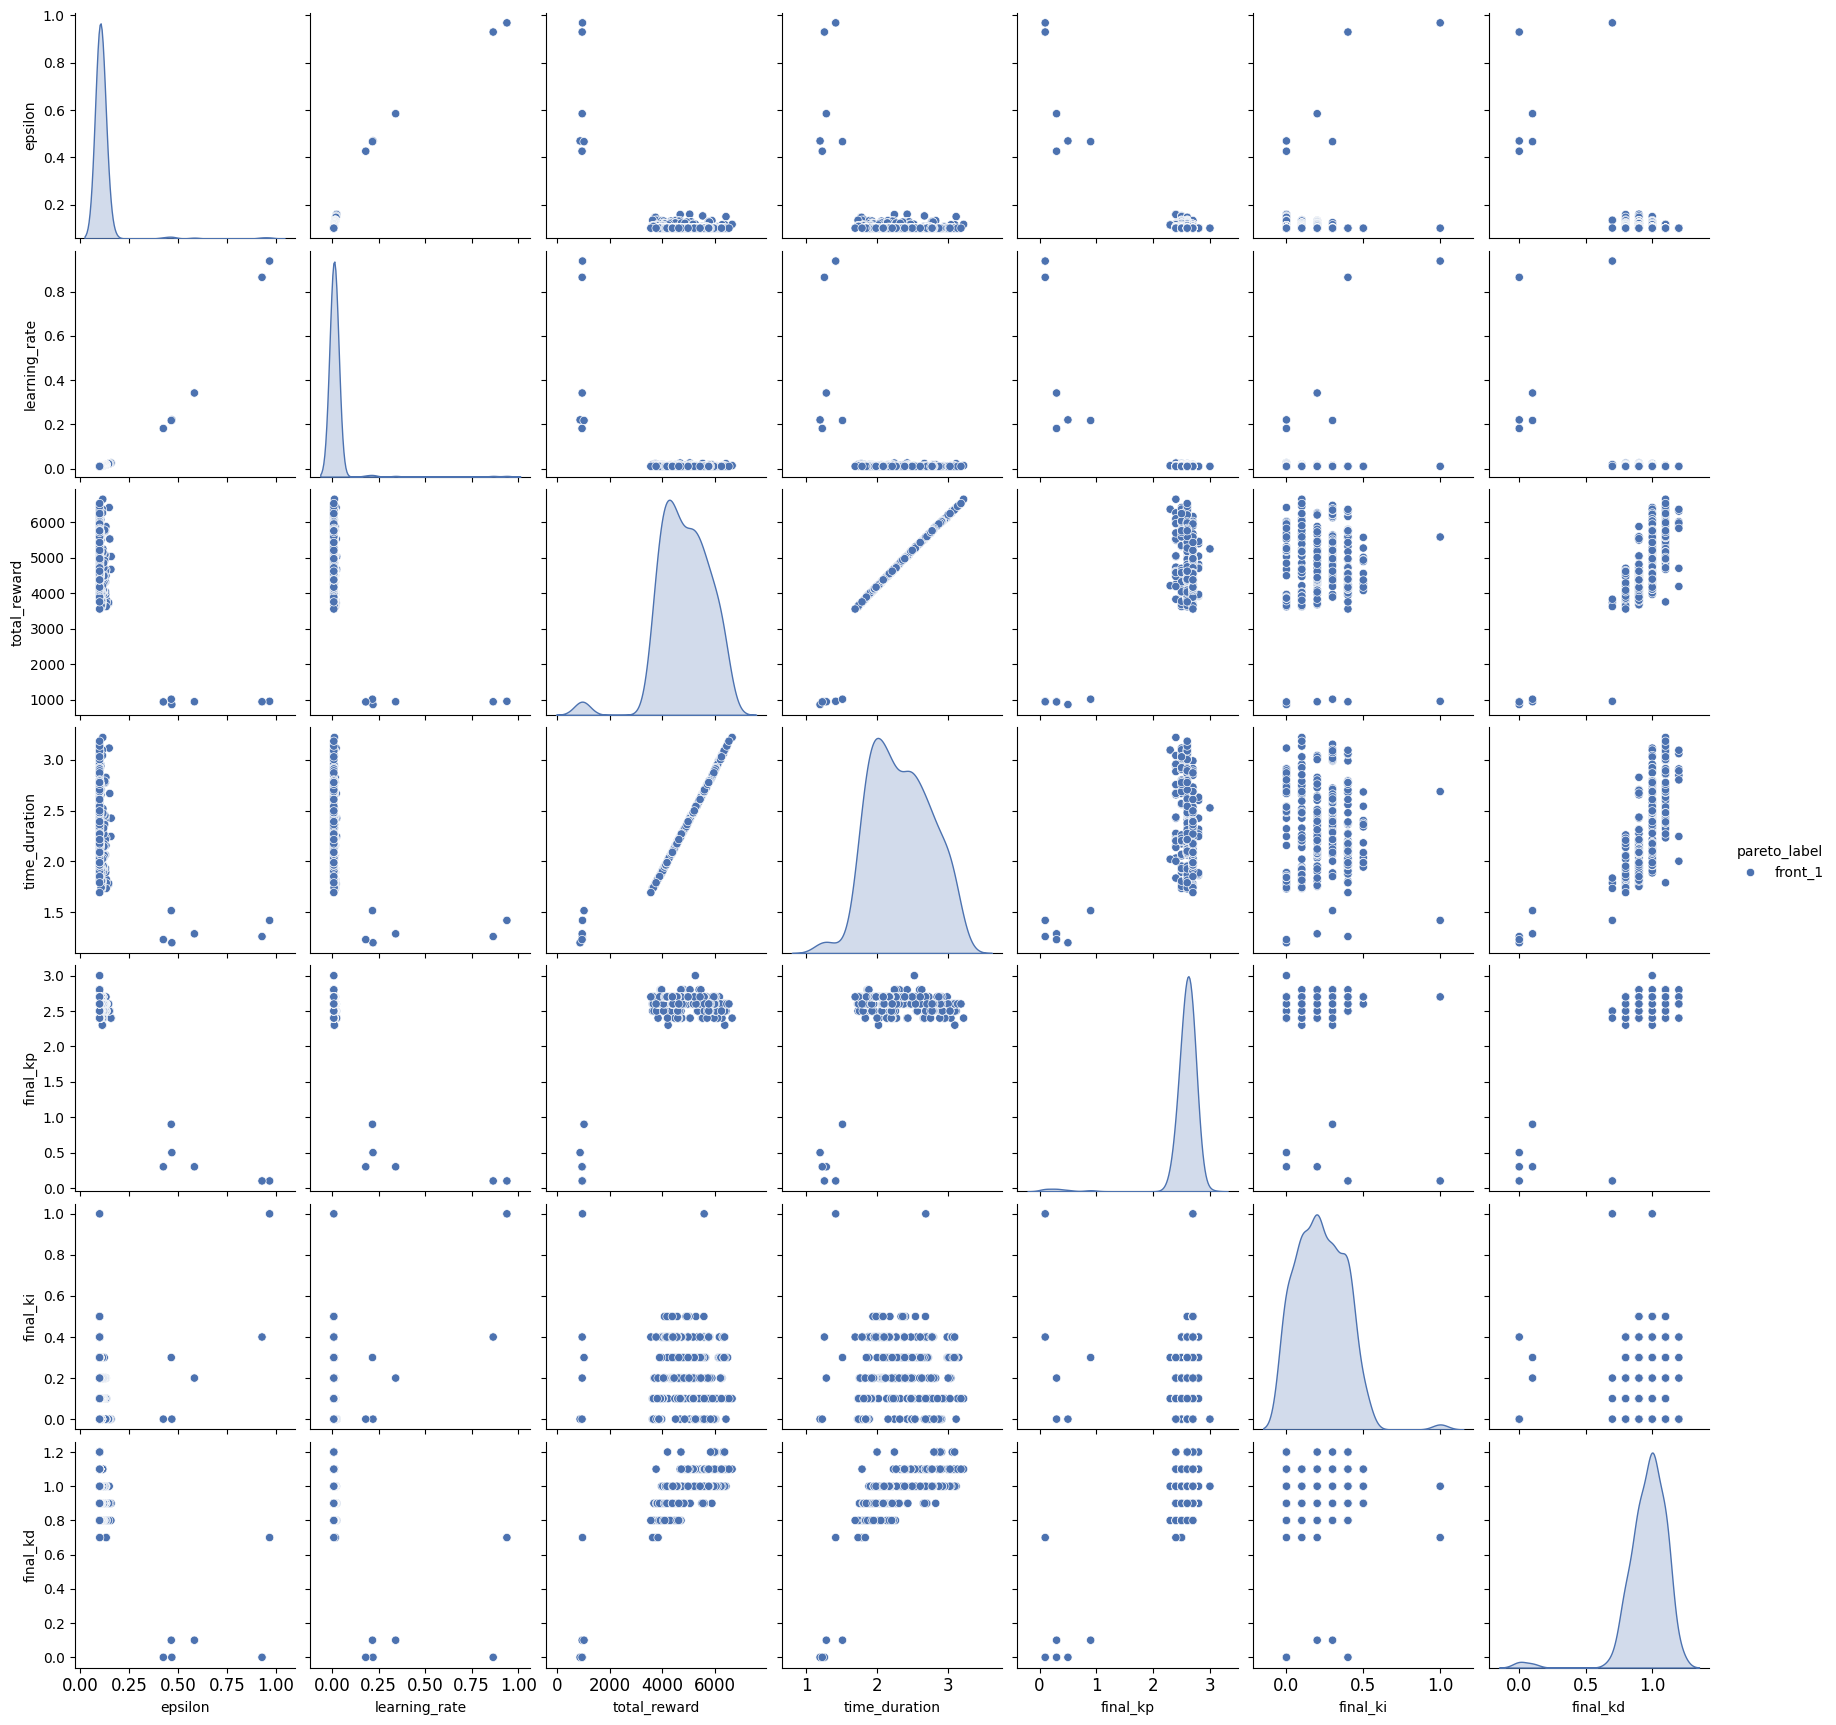

In [78]:
vars_pair = ['epsilon', 'learning_rate', 'total_reward', 'time_duration', 'final_kp', 'final_ki', 'final_kd']
plot_pairplot(df2, vars_list=vars_pair, hue='pareto_label')

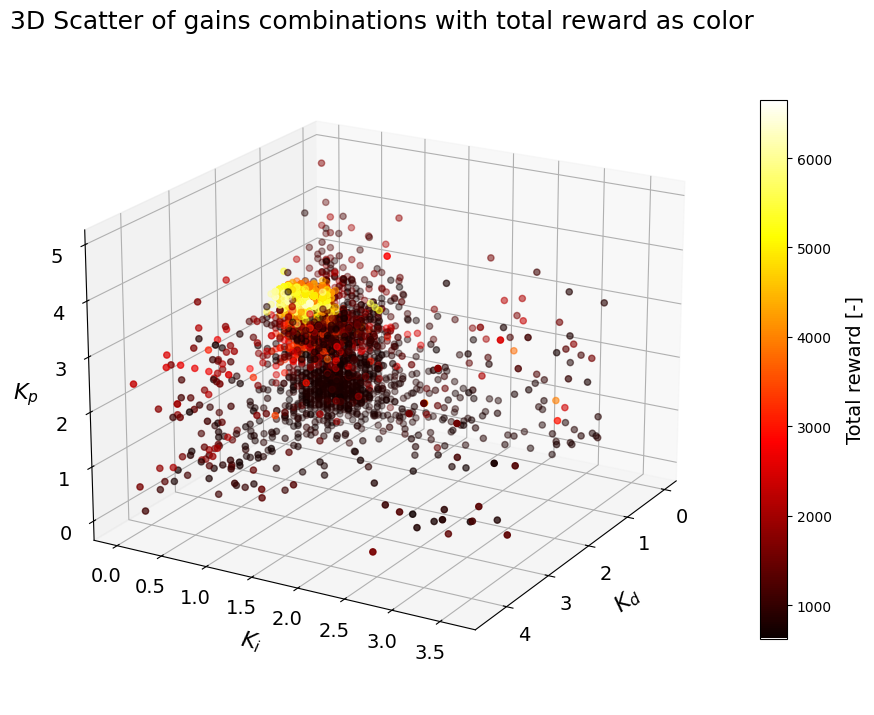

In [214]:
plot_3d_scatter(df2, x='final_kd', y='final_ki', z='final_kp', color='total_reward',
                marker_by=None, elev=20, azim=30, save_fig=True)

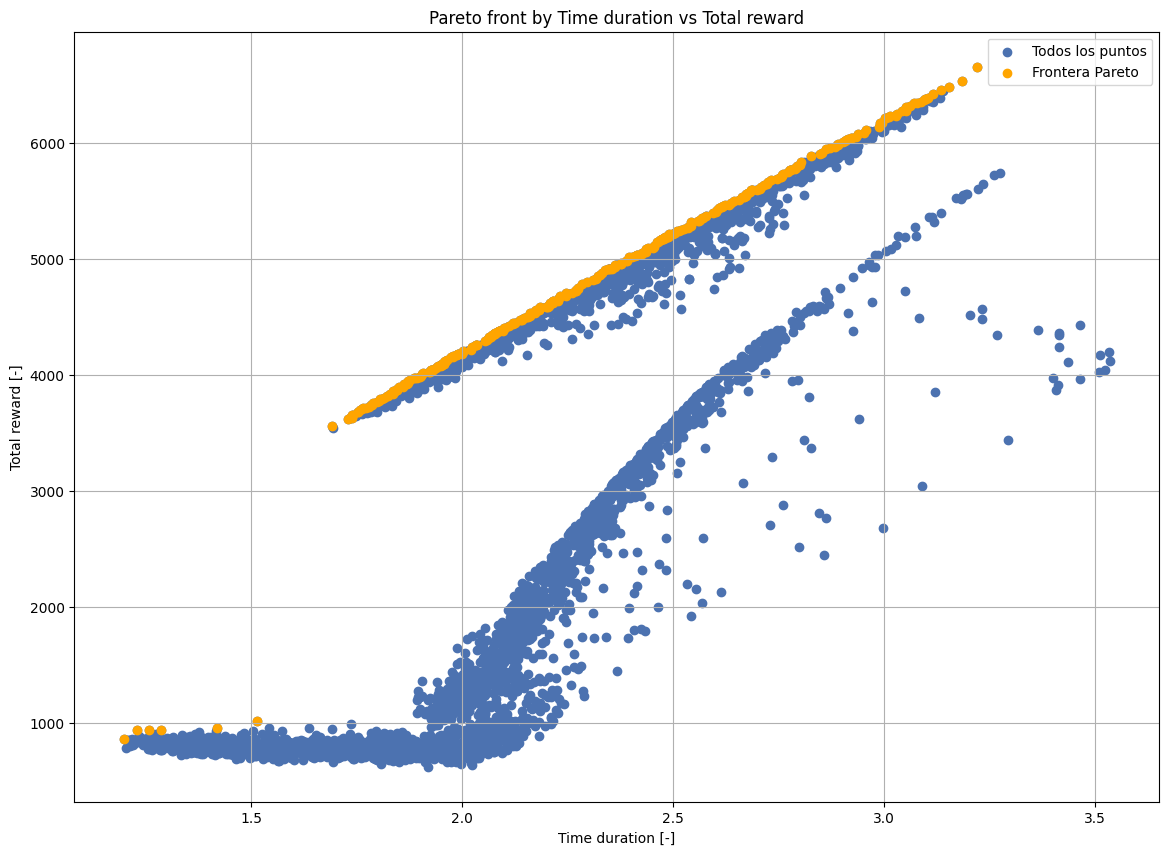

In [92]:
plot_pareto(df2,
            x='time_duration', y='total_reward',
            highlight_color='orange')

In [2]:
import pandas as pd
import numpy as np
import math

from datetime import datetime

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from matplotlib.pyplot import figure

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Otras Visualizaciones

In [94]:
df2.columns

Index(['episode', 'epsilon', 'learning_rate', 'time_duration',
       'termination_reason', 'total_reward', 'final_kp', 'final_ki',
       'final_kd', 'pareto_label', 'freq_pareto'],
      dtype='object')

In [100]:
df_num = df2.drop(['termination_reason','pareto_label', 'freq_pareto'],axis=1)
df_num.columns

Index(['episode', 'epsilon', 'learning_rate', 'time_duration', 'total_reward',
       'final_kp', 'final_ki', 'final_kd'],
      dtype='object')

In [102]:
df_num.describe()

,episode,epsilon,learning_rate,time_duration,total_reward,final_kp,final_ki,final_kd
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2499.500000,0.332602,0.173972,2.118227,2974.929361,1.873080,0.302560,0.773860
std,1443.520003,0.251536,0.237830,0.432507,1858.865382,0.789357,0.439896,0.569645
min,0.000000,0.100000,0.010000,1.198000,626.795867,0.000000,0.000000,0.000000
25%,1249.750000,0.115462,0.013363,1.852000,847.547229,1.400000,0.100000,0.400000
50%,2499.500000,0.237070,0.056290,2.115000,3221.274122,2.200000,0.200000,0.800000
75%,3749.250000,0.486758,0.237120,2.412000,4645.270316,2.500000,0.400000,1.000000
max,4999.000000,0.999425,0.998850,3.535000,6654.299625,4.900000,3.600000,4.400000


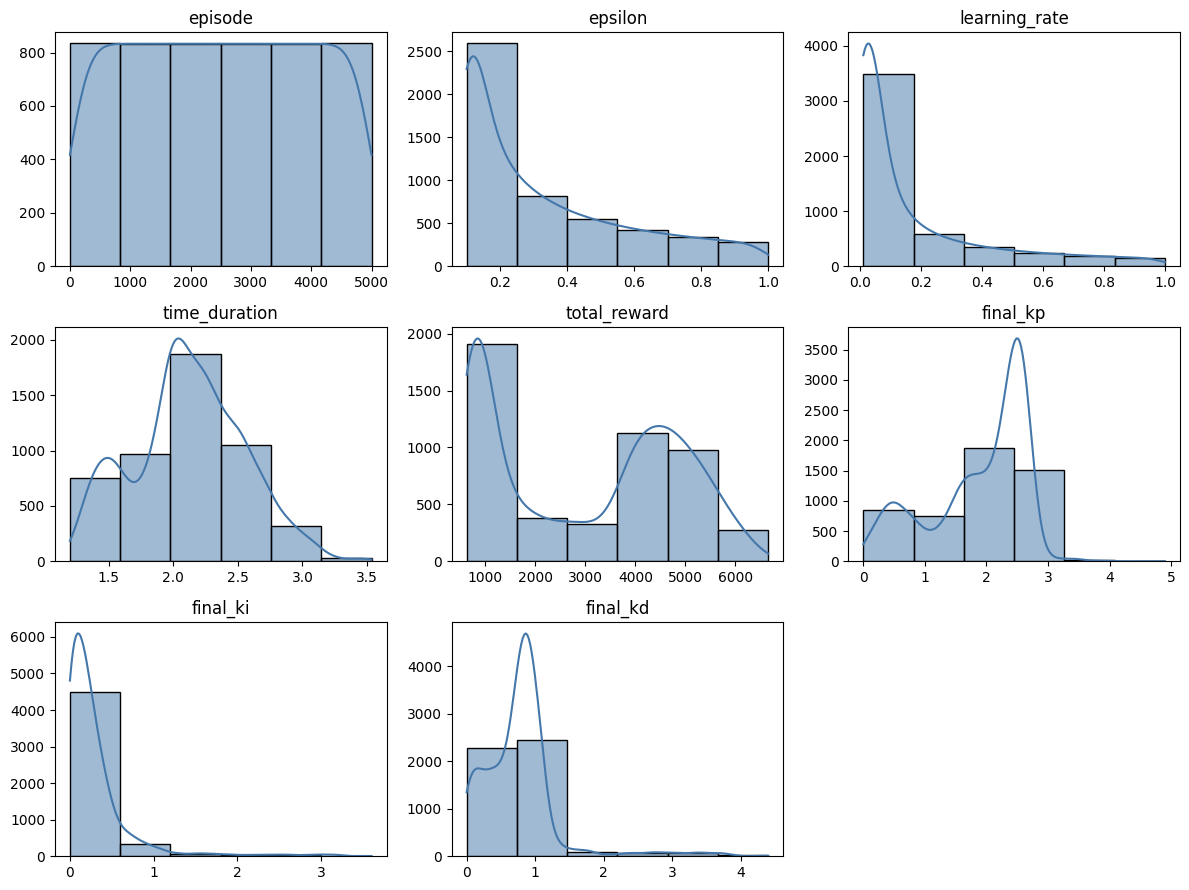

In [104]:
cols = df_num.columns
# --- Histogramas por cols ---
n_cols = 3
n_var = len(cols)
n_rows = math.ceil(n_var / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(df_num[col], bins=6, kde=True, ax=axes[i], color='#4477AA')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout();
plt.show();

<Figure size 1000x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation matrix of Pearson')

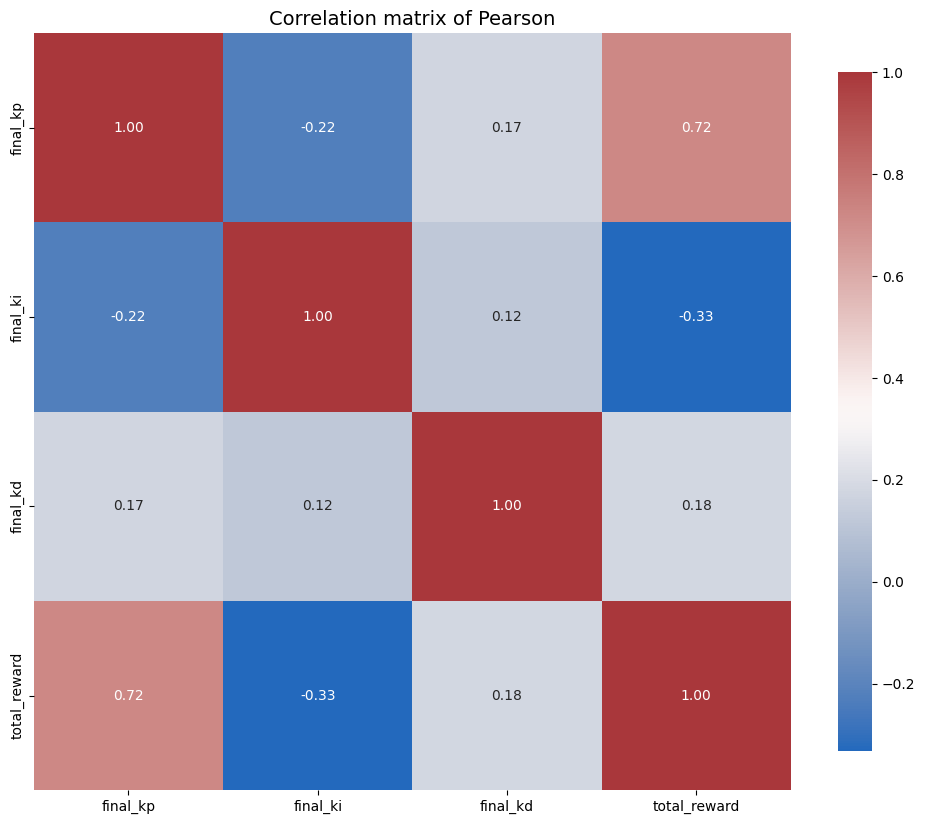

In [110]:
# ---- Matriz de Correlación Pearson ----
cols_corr = ['final_kp', 'final_ki', 'final_kd', 'total_reward']
corr = df2[cols_corr].corr(method='pearson')

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', cbar_kws={"shrink": 0.7}, square=True)
plt.title('Correlation matrix of Pearson', fontsize=14)
plt.tight_layout()
#plt.savefig('output\\fig2_corr_highCorr', dpi=500)                       # *** CHANGE NAME
plt.show()